##Naive forecasting

##Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

##Trend and Seasonality

In [0]:
def trend(time, slope=0):
    return slope * time

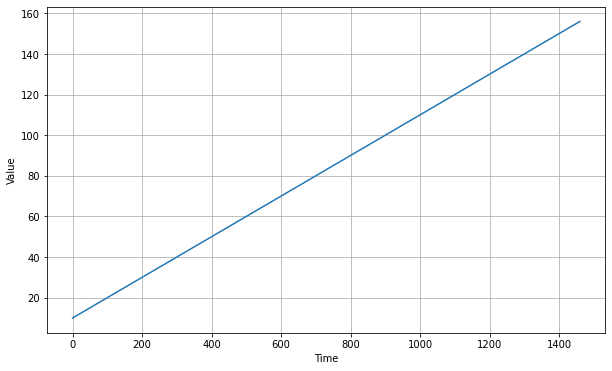

In [4]:

time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [6]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

In [0]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

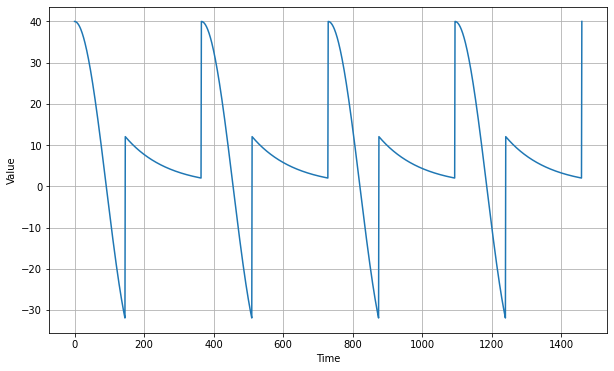

In [8]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

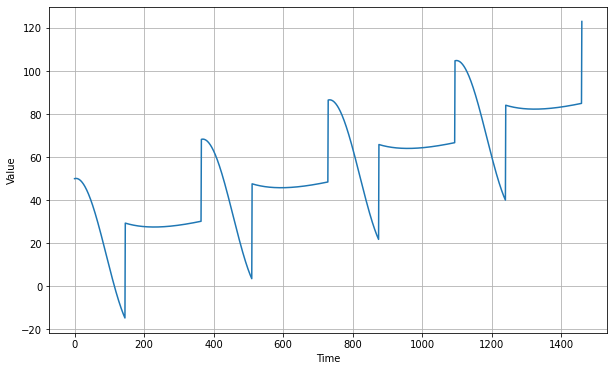

In [9]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

##Noise

In [0]:

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

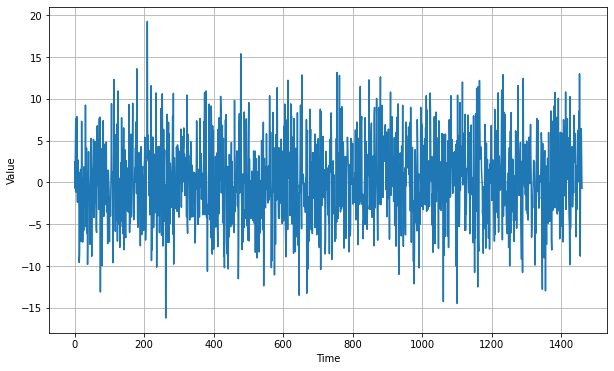

In [11]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

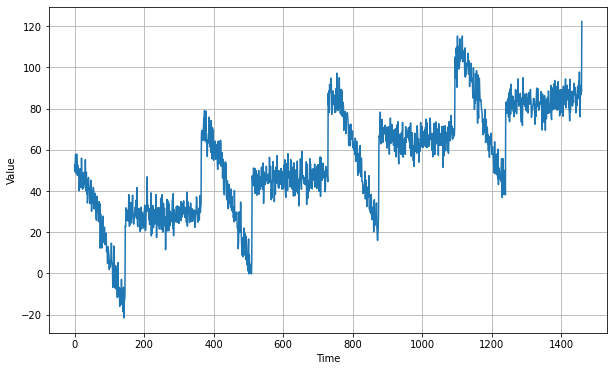

In [12]:

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
from tensorflow import keras
import tensorflow as tf

In [0]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [0]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

##LSTM RNN Forecasting

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 0s 7ms/step - loss: 90.9191 - mae: 91.4191 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 6ms/step - loss: 83.8978 - mae: 84.3978 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 0s 6ms/step - loss: 75.4974 - mae: 75.9974 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 0s 6ms/step - loss: 66.0676 - mae: 66.5676 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 0s 6ms/step - loss: 55.5131 - mae: 56.0131 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 43.7599 - mae: 44.2597 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 0s 6ms/step - loss: 30.7909 - mae: 31.2900 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 0s 6ms/step - loss: 17.1478 - mae: 17.6436 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 0s 5ms/step - loss: 10.0311 - mae: 10.5178 

(1e-08, 0.0001, 0.0, 30.0)

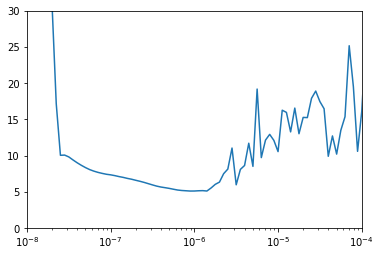

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 1s 26ms/step - loss: 30.0122 - mae: 30.5050 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 0s 8ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 0s 8ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 0s 8ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 0s 8ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 0s 9ms/st

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

In [0]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

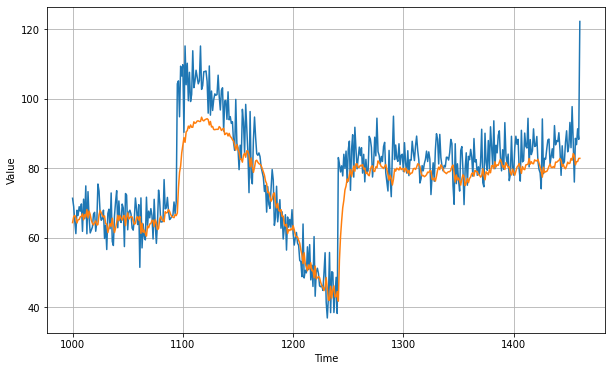

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [27]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.9702973